## Segmentation:
Interested in several things and trying to identify the following for each customer:
- days since last purchase
    - take 2015-01-01 as "now", create 'DaysSinceLastPurch'
    - for each customer, sort txn with DaysSinceLastPurch, ascending
    - retrieve first DaysSinceLastPurch
- sleeper: those who did not buy for over 6 months
    - DaysSinceLastPurch > 180
- (On hold) hot: salesLast3Mth > threshold
    - 
- frequent buyer: who shop 10 times or above, in last 12 months
    - for each customer, group txn by year, unique memo no. per year
    - length of unique memo no. per year > 10
- (On hold) festive buyer: who always buy during major festival (new year, CNY, Easter, labor day, national day, thanks giving, Xmas) 
- high lifetime value
    - calculate 3 yr total sales for each customer
    - top 20%
- Big Spender - high per order purchase
    - group txn per customer per memo in sales
    - identify mean memo sales
    - customer with 3 memo sales > mean, in last 12 months --> Big Spender
- Discount Lover
    - group txn per customer per memo in discount
    - identify mean memo discount
    - customer with 3 memo discount > mean, in last 12 months


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 70)

##Cust: import data

In [3]:
tp = pd.read_csv('1_Member_stripped.csv', iterator=True, chunksize=1000) # gives TextFileReader, which is iteratable with chunks of 1000 rows.
cust = pd.concat(tp, ignore_index=True) # df is DataFrame. If error do list(tp)

In [4]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98001 entries, 0 to 98000
Data columns (total 68 columns):
id                      98001 non-null int64
CustomerKey             98001 non-null int64
MemberId                98000 non-null object
FullName                97996 non-null object
Title                   96399 non-null object
Gender                  96915 non-null object
MaritalStatus           41405 non-null object
BirthYear               98000 non-null float64
HasDOB                  98001 non-null object
Age                     98001 non-null object
Nationality             97993 non-null object
AreaCode                92982 non-null object
DistrictCode            92982 non-null object
ZipCode                 0 non-null float64
AllowMail               98001 non-null object
AllowPhone              91799 non-null object
AllowSMS                97968 non-null object
AllowEmail              98000 non-null object
HasAddress              98001 non-null object
HasPhone             

In [5]:
# eliminate redundant columns
features = cust.columns.tolist()

features_redundant = [
 'id',
 'CustomerKey',
 'Title',
 'MemberId',
 'FullName',
 'StartDate_bak',
 'EndDate_bak',
 'JoinDate_bak',
 'Pigment',
 'Epidermis',
 'Sebum',
 'Sensitivity',
 'Dehydrate',
 'SideEffect',
 'Income',
 'Education',
 'SendInfo',
 'QWhere',
 'FavSkinCare',
 'FavPerfume',
 'FavMakeUp',
 'Concern',
 'QReadMag',
 'QSubMag',
 'UpdateDate_bak',
 'JoinCounterNameLocal',
 'TotalSpend',
 'OSBPoints',
 'AsiaMiles',
 'CounterNameLocal',
 'ZipCode',
 'ReasonCode',
 'UpdateDate',
 'BirthYear',
 'StartDate',
 'TotalVisits',
 'EndDate',
 'JoinDate',
 'LastPurchaseDate',
 'DistrictCode',
 'AsiaMiles_ModifyDate',
 'CurrentCounter',
 'CustomerType',
 'JoinCounter',
 'CounterNameEng',
 'LastActiveDate', # use txn data to build this feature instead
 'LifeVisits' # use txn data to build this feature instead
]

for f in features_redundant:
    features.remove(f)
    
cust[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98001 entries, 0 to 98000
Data columns (total 21 columns):
Gender                 96915 non-null object
MaritalStatus          41405 non-null object
HasDOB                 98001 non-null object
Age                    98001 non-null object
Nationality            97993 non-null object
AreaCode               92982 non-null object
AllowMail              98001 non-null object
AllowPhone             91799 non-null object
AllowSMS               97968 non-null object
AllowEmail             98000 non-null object
HasAddress             98001 non-null object
HasPhone               98001 non-null object
HasEmail               98001 non-null object
Occupation             542 non-null object
Language               93562 non-null object
MemberType             97999 non-null object
ReasonDesc             98000 non-null object
StoreGroup             92837 non-null object
LastPurchaseCounter    90575 non-null float64
SkinType               1718 non-null 

##Txn: import data

In [10]:
tp = pd.read_csv('1_Transactions_2012.csv', iterator=True, chunksize=1000) # gives TextFileReader, which is iteratable with chunks of 1000 rows.
txn12 = pd.concat(tp, ignore_index=True) # df is DataFrame. If error do list(tp)

In [11]:
tp = pd.read_csv('1_Transactions_2013.csv', iterator=True, chunksize=1000) # gives TextFileReader, which is iteratable with chunks of 1000 rows.
txn13 = pd.concat(tp, ignore_index=True) # df is DataFrame. If error do list(tp)

In [12]:
tp = pd.read_csv('1_Transactions_2014.csv', iterator=True, chunksize=1000) # gives TextFileReader, which is iteratable with chunks of 1000 rows.
txn14 = pd.concat(tp, ignore_index=True) # df is DataFrame. If error do list(tp)

In [13]:
txn = pd.concat([txn12, txn13, txn14])

# reset index as running numbers (integers)
txn.index = range(len(txn.index))

txn.head()

,Date,TxnTypeLName,POS Memo,Shop Code,Shop,Customer,Item,Counter,TxnType,CustomerType,Visit,Reason,CustomerAge,Staff,MemoNo,VirtualNo,SeqNo,Qty,GrossAmt,Discount,BonusPoints,q1,q2,q3,q4,q5,UpdateDate,rn,CounterNameLocal,StoreGroup,Region,Distribution,AreaManager,Description
0,2012-01-01,CS,2012-01-01351386068777,3513870,LCCR,10949,11258,13,5,6,5,11,0,288,68777,351GUE38600101000006877720120101,1,1,8361.6,0,1340,Female,Tourist,Others,Regular,55 or above,01/02/12 04:51 PM,1222079,LC CR,LANE CRAWFORD GROUP,NaN,NaN,NaN,Cash Sales
1,2012-01-01,CS,2012-01-01351353147766,3513531,HN LM,65112,8684,18,5,6,1,14,6,308,47766,351GUE35310101000004776620120101,3,1,3120.0,0,500,Female,Local,Hong Kong,Regular,35 - 44,01/04/12 05:13 AM,1222080,HN LM,HARVEY NICHOLS,NaN,NaN,NaN,Cash Sales
2,2012-01-01,CS,2012-01-01351350592334,3513505,SOGO CWB,46273,11269,3,5,6,2,11,3,263,92334,351GUE35050101000009233420120101,1,1,3744.0,0,600,Female,Tourist,Mainland China,Regular,24 or below,01/02/12 04:51 PM,1222081,SOGO CWB,SOGO GROUP,NaN,NaN,NaN,Cash Sales
3,2012-01-01,CS,2012-01-01351380049020,3513800,FTW Boutique,64902,10716,10,5,6,1,14,6,241,49020,351GUE38000101000004902020120101,1,1,2246.4,0,360,Female,Tourist,Mainland China,Regular,35 - 44,01/02/12 04:51 PM,1222082,FTW Boutique,FESTIVAL WALK BOUTIQ,NaN,NaN,NaN,Cash Sales
4,2012-01-01,CS,2012-01-01351380049014,3513800,FTW Boutique,28240,8668,10,5,6,5,11,7,241,49014,351GUE38000101000004901420120101,1,1,2995.2,0,480,Female,Local,Hong Kong,Non-regular,35 - 44,01/02/12 04:51 PM,1222083,FTW Boutique,FESTIVAL WALK BOUTIQ,NaN,NaN,NaN,Cash Sales


In [49]:
txn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690909 entries, 0 to 758299
Data columns (total 37 columns):
Date                  690909 non-null object
TxnTypeLName          690909 non-null object
POS Memo              690909 non-null object
Shop Code             690909 non-null int64
Shop                  690909 non-null object
Customer              690909 non-null int64
Item                  690909 non-null int64
Counter               690909 non-null int64
TxnType               690909 non-null int64
CustomerType          690909 non-null int64
Visit                 690909 non-null int64
Reason                690909 non-null int64
CustomerAge           690909 non-null int64
Staff                 690909 non-null int64
MemoNo                690909 non-null int64
VirtualNo             690909 non-null object
SeqNo                 690909 non-null int64
Qty                   690909 non-null int64
GrossAmt              690909 non-null float64
Discount              690909 non-null float64


In [14]:
# take away redundant features from txn
t_features_redundant = [
    'rn',
    'Region',
    'Distribution',
    'AreaManager',
    'UpdateDate',
    'VirtualNo',
    'CounterNameLocal', # add back into t_features after cleaning up this column of data
    'Date',
    'Shop Code',
    'Counter',
    'TxnType',
    'CustomerType',
    'Visit',
    'Reason',
    'CustomerAge',
    'MemoNo',
    'BonusPoints',
    'TxnTypeLName',
    'POS Memo'
]

t_features = txn.columns.tolist()

for feat in t_features_redundant:
    t_features.remove(feat)
    
txn[t_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758301 entries, 0 to 758300
Data columns (total 15 columns):
Shop           758301 non-null object
Customer       758301 non-null int64
Item           758301 non-null int64
Staff          758301 non-null int64
SeqNo          758301 non-null int64
Qty            758301 non-null int64
GrossAmt       758301 non-null float64
Discount       758301 non-null float64
q1             733426 non-null object
q2             733426 non-null object
q3             733426 non-null object
q4             733426 non-null object
q5             733426 non-null object
StoreGroup     579733 non-null object
Description    758301 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 92.6+ MB


##Cust: checking for needs of padding and dropping rows

In [15]:
# Why MemberId is null
cust[cust['MemberId'].isnull()]

# --> walk in customer
# --> as MemberId is same as CustomerKey, MemberID is redundant

,id,CustomerKey,MemberId,FullName,Title,Gender,MaritalStatus,BirthYear,HasDOB,Age,Nationality,AreaCode,DistrictCode,ZipCode,AllowMail,AllowPhone,AllowSMS,AllowEmail,HasAddress,HasPhone,HasEmail,Occupation,Language,CustomerType,MemberType,ReasonCode,ReasonDesc,StartDate,StartDate_bak,EndDate,EndDate_bak,JoinDate,JoinDate_bak,JoinCounter,StoreGroup,CurrentCounter,CounterNameEng,CounterNameLocal,LastActiveDate,LastPurchaseDate,LastPurchaseCounter,OSBPoints,AsiaMiles,AsiaMiles_ModifyDate,TotalSpend,TotalVisits,LifeVisits,SkinType,Pigment,Epidermis,Sebum,Sensitivity,Dehydrate,SideEffect,Income,Education,SendInfo,QWhere,FavSkinCare,FavPerfume,FavMakeUp,Concern,QReadMag,QSubMag,UpdateDate,UpdateDate_bak,JoinCounterNameEng,JoinCounterNameLocal
98000,0,0,NaN,- walk in -,NaN,NaN,NaN,NaN,Yes,Undefined,Others,NaN,NaN,NaN,N,NaN,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0000-00-00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-12-23,12/23/05 04:33 PM,NaN,NaN


In [16]:
# check Title=null rows
cust_without_title = cust[cust['Title'].isnull() & cust['Gender'].isnull() & cust['MemberId']!=0]['CustomerKey']

print 'no. of rows without title:', len(cust_without_title)


no. of rows without title: 1084


In [17]:
a = txn[txn['Customer'].isin(cust_without_title)]['GrossAmt'].sum()
b = txn['GrossAmt'].sum()
print 'Without-title customer covers how much % of sales:', a/b


Without-title customer covers how much % of sales: 0.0178727292502


In [19]:
# check Nationality = null rows
cust_without_nationality = cust[cust['Nationality'].isnull()]['CustomerKey']
cust[cust['Nationality'].isnull()][features]
print 'no. of customer without nationality:', len(cust[cust['Nationality'].isnull()])

# check total sales of those without nationality
a = txn[txn['Customer'].isin(cust_without_nationality)]['GrossAmt'].sum()
b = txn['GrossAmt'].sum()
print '% of sales from customer without nationality:',a/b

# --> trivial sales

no. of customer without nationality: 8
% of sales from customer without nationality: 0.000287735300848


In [20]:
# Padding for AllowMail, AllowPhone, AllowSMS, AllowEmail
# note: if null, assume not allowed, i.e. 'N'

cust.ix[cust[cust['AllowPhone'].isnull()].index, 'AllowPhone'] = 'N'
cust.ix[cust[cust['AllowSMS'].isnull()].index, 'AllowSMS'] = 'N'
cust.ix[cust[cust['AllowEmail'].isnull()].index, 'AllowEmail'] = 'N'

In [21]:
print cust['AllowPhone'].value_counts()
print cust['AllowSMS'].value_counts()
print cust['AllowEmail'].value_counts()

# --> space trimming required for 'AllowPhone'

N     89859
N      6202
Y      1940
dtype: int64
Y    64683
N    33318
dtype: int64
Y    58774
N    39227
dtype: int64


In [22]:
# drop MemberType-null rows
# note: sales for MemberType-null is zero
# note: ALSO dropped walk-in customer
idx = cust[cust['MemberType'].isnull()].index
cust = cust.drop(idx)

In [27]:
# check if AreaCode-null cust are of high importance, in sales

cust_AreaCode_null = cust[cust['AreaCode'].isnull()]['CustomerKey'].tolist()
print txn[txn['Customer'].isin(cust_AreaCode_null)]['GrossAmt'].sum()/ txn['GrossAmt'].sum()

# --> minor

# cust[cust['AreaCode'].isnull()]['LifeVisits'].value_counts()

0.0260503391489


##Cust: trim space for str type (or Object) features 

In [28]:
# cust: inspect unique values of each categorical columns - trying to identify features
   
count = 0    
for f in features:
    count +=1
    print count, '.', f, ':'
    print cust[f].unique()
    print cust[f].value_counts()
    print
    
# action items:
# - AreaCode > 'HONG KONG' --> 'Hong Kong'

1 . Gender :
['F' nan 'M']
F    94491
M     2423
dtype: int64

2 . MaritalStatus :
[nan 'Single' 'Married']
Single     41196
Married      208
dtype: int64

3 . HasDOB :
['Yes' 'No']
Yes    91987
No      6012
dtype: int64

4 . Age :
['60 or above' '45~49' '50~54' 'Undefined' '40~44' '55~59' '35~39' '30~34'
 '25~29' '19 or below' '20~24']
30~34          23854
Undefined      17460
40~44          14986
25~29          12408
35~39          12260
45~49           5955
50~54           4376
20~24           3277
60 or above     1704
55~59           1582
19 or below      137
dtype: int64

5 . Nationality :
['Hong Kong' 'Mainland China' 'Others' 'Macau' nan]
Mainland China    66300
Hong Kong         26160
Macau              3214
Others             2317
dtype: int64

6 . AreaCode :
['Hong Kong' 'Kowloon' 'New Territories' 'China' 'Others' 'Macau' nan
 'HONG KONG']
China              59848
Hong Kong          21288
Kowloon             4505
New Territories     3785
Macau               2931
Others      

In [29]:
# identify columns that are string (i.e. object) type
col = cust[features].select_dtypes(include=['object']).columns.tolist()

for c in col:
    cust[c] = cust[c].str.rstrip()
    print 'trimmed feautre:', c
    print cust[c].unique()
    print

trimmed feautre: Gender
['F' nan 'M']

trimmed feautre: MaritalStatus
[nan 'Single' 'Married']

trimmed feautre: HasDOB
['Yes' 'No']

trimmed feautre: Age
['60 or above' '45~49' '50~54' 'Undefined' '40~44' '55~59' '35~39' '30~34'
 '25~29' '19 or below' '20~24']

trimmed feautre: Nationality
['Hong Kong' 'Mainland China' 'Others' 'Macau' nan]

trimmed feautre: AreaCode
['Hong Kong' 'Kowloon' 'New Territories' 'China' 'Others' 'Macau' nan
 'HONG KONG']

trimmed feautre: AllowMail
['Y' 'N']

trimmed feautre: AllowPhone
['N' 'Y']

trimmed feautre: AllowSMS
['N' 'Y']

trimmed feautre: AllowEmail
['N' 'Y']

trimmed feautre: HasAddress
['N' 'Y']

trimmed feautre: HasPhone
['N' 'Y']

trimmed feautre: HasEmail
['N' 'Y']

trimmed feautre: Occupation
[nan 'White Collar' 'Secretary' 'Professionals eg.Doctor,Lawyer'
 'Housewife' 'Others' 'Director/General Manager' 'Owner/Partner' 'Excutive'
 'Manager/Department Head' 'Student' 'Blue Collar' 'Retired/Unemployed'
 'CLERK' 'ACCOUNTANT' 'doctor' 'lawye

In [30]:
# AreaCode: 'HONG KONG' --> 'Hong Kong'
cust.loc[cust[cust['AreaCode']=='HONG KONG'].index, 'AreaCode'] = 'Hong Kong'

##Cust: check features correlation

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1292: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


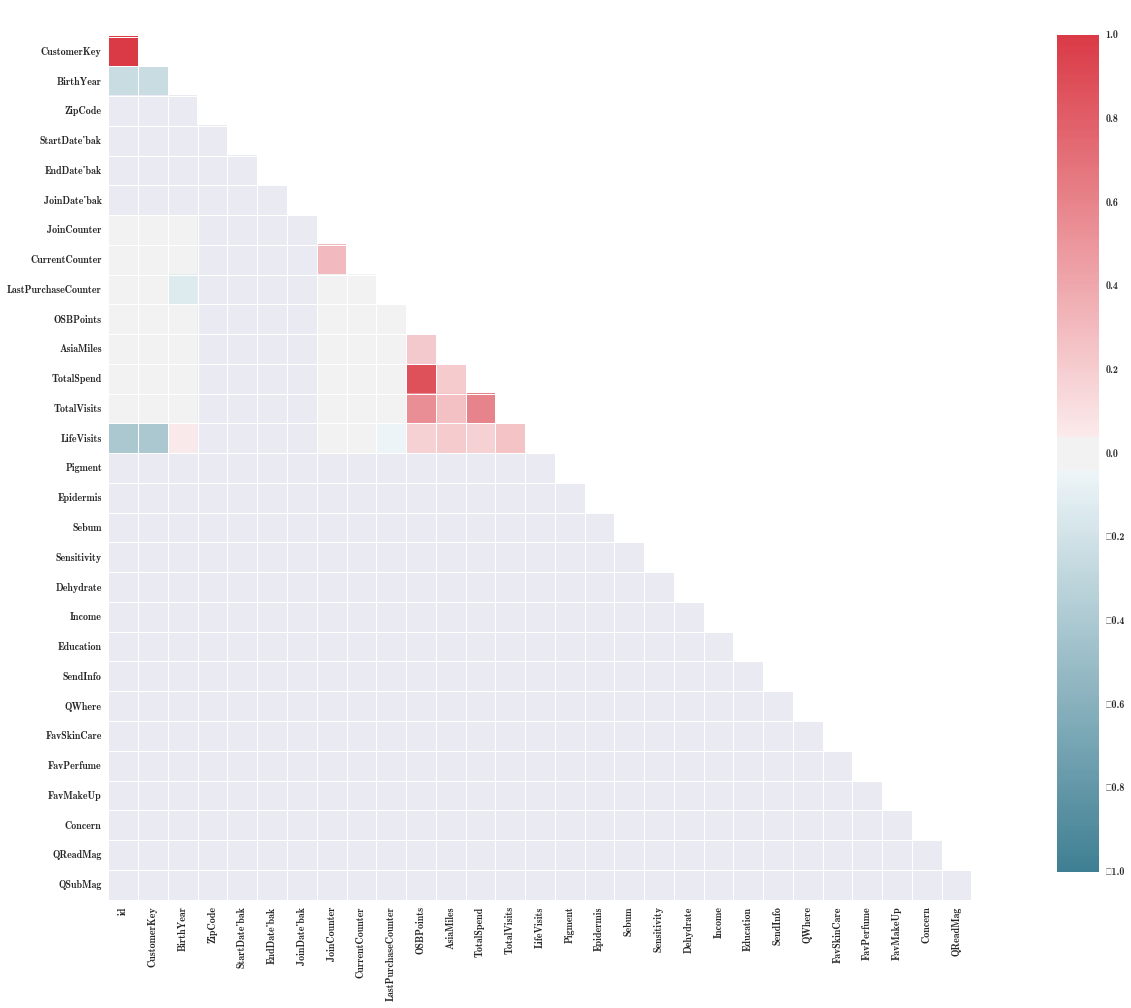

In [31]:
# look for highly correlated features

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(cust, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap)

# --> no selected features are highly correlated

##Txn: check for needs of padding and dropping rows

In [33]:
# inspect customer attributes q1 to q5,
# and store the them in txn_q1to5_null
txn_q1to5_null = txn[txn['q1'].isnull() & txn['q2'].isnull() & txn['q3'].isnull() & txn['q4'].isnull() & txn['q5'].isnull()].copy()
idx = txn_q1to5_null.index
print 'number of txn with q1 to q5 all null =', len(idx)
print
# --> there are 24875 txn have all q1 to q5 = null


# check if the to-be-dropped rows got significant sales
print 'Total sales in q1-to-q5-null rows =', txn.loc[idx]['GrossAmt'].sum()
print 'There are', len(txn.ix[idx][txn['GrossAmt']!=0]), 'rows with sales not zero.'
print

# --> It is fine to dropped those rows
txn = txn.dropna(how='all', subset = ['q1','q2','q3','q4','q5'])
print 'q1-to-q5-null txn dropped'


number of txn with q1 to q5 all null = 0

Total sales in q1-to-q5-null rows = 0
There are 0 rows with sales not zero.

q1-to-q5-null txn dropped


In [34]:
txn[t_features].info()

# padding required for StoreGroup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733426 entries, 0 to 758300
Data columns (total 15 columns):
Shop           733426 non-null object
Customer       733426 non-null int64
Item           733426 non-null int64
Staff          733426 non-null int64
SeqNo          733426 non-null int64
Qty            733426 non-null int64
GrossAmt       733426 non-null float64
Discount       733426 non-null float64
q1             733426 non-null object
q2             733426 non-null object
q3             733426 non-null object
q4             733426 non-null object
q5             733426 non-null object
StoreGroup     558438 non-null object
Description    733426 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 89.5+ MB


In [35]:
# inspect unique values in str-type column - for potential featuers

txn_str_col = txn[t_features].select_dtypes(include=['object']).columns.tolist()
print 'features of str type:', txn_str_col
print

count = 0
for feat in txn_str_col:
    count += 1
    print count, '.', feat, ':'
    print txn[feat].unique().tolist()
    print txn[feat].value_counts()
    print    

features of str type: ['Shop', 'q1', 'q2', 'q3', 'q4', 'q5', 'StoreGroup', 'Description']

1 . Shop :
['LCCR', 'HN LM', 'SOGO CWB            ', 'FTW Boutique        ', 'SOGO TST            ', 'LP', 'Macau New Yaohan    ', 'The ONE', 'LCTSQ', 'Staff Sales         ', 'Central Boutique', 'HN PP               ', 'FTW', 'LC IFC              ', 'Macau', 'GUERLAIN STAFF SALES', 'WO MAIN             ', 'WO PLUS TSTE        ', 'HN The One          ', 'Central Boutique    ', 'PRIVATE SALE        ', 'HN LM               ']
LCCR                    142302
Macau New Yaohan        140320
SOGO CWB                 88400
HN LM                    79832
LCTSQ                    64103
LP                       42344
FTW Boutique             39163
The ONE                  34845
HN PP                    30782
SOGO TST                 25375
Central Boutique         10891
Macau                     6951
PRIVATE SALE              6558
Staff Sales               4663
LC IFC                    4081
FTW              

In [36]:
# trim space for all str-type column
print txn_str_col
print

for c in txn_str_col:
    txn[c] = txn[c].str.rstrip()
    print 'trimmed feature:', c
    print txn[c].unique().tolist()
    print

['Shop', 'q1', 'q2', 'q3', 'q4', 'q5', 'StoreGroup', 'Description']

trimmed feature: Shop
['LCCR', 'HN LM', 'SOGO CWB', 'FTW Boutique', 'SOGO TST', 'LP', 'Macau New Yaohan', 'The ONE', 'LCTSQ', 'Staff Sales', 'Central Boutique', 'HN PP', 'FTW', 'LC IFC', 'Macau', 'GUERLAIN STAFF SALES', 'WO MAIN', 'WO PLUS TSTE', 'HN The One', 'PRIVATE SALE']

trimmed feature: q1
['Female', 'Male']

trimmed feature: q2
['Tourist', 'Local']

trimmed feature: q3
['Others', 'Hong Kong', 'Mainland China', 'Macau']

trimmed feature: q4
['Regular', 'Non-regular']

trimmed feature: q5
['55 or above', '35 - 44', '24 or below', '25 - 34', '45 - 54']

trimmed feature: StoreGroup
['LANE CRAWFORD GROUP', 'HARVEY NICHOLS', 'SOGO GROUP', 'FESTIVAL WALK BOUTIQ', 'SEIBU', 'PANDA SOCIEDADE', 'STAFF SALES POINT', 'BOUTIQUE', nan]

trimmed feature: Description
['Cash Sales', 'Exchange', 'Refund']



In [31]:
# inspect rows with StoreGroup is null
txn_sg_null = txn[t_features][txn['StoreGroup'].isnull()]
print 'StoreGroup-null txn sales subtotal =', txn_sg_null['GrossAmt'].sum()
print '% of total sales:', txn_sg_null['GrossAmt'].sum()/ txn['GrossAmt'].sum()

# these row includes 22% of sales --> padding to keep these rows

 StoreGroup-null txn sales subtotal = 1109847835.2
% of total sales: 0.227507678074


In [37]:
# Pad the StoreGroup null fields:

# First, build Shop-StoreGroup unique pairs - padding preparation
# then look up the StoreGroup values by shop value
# keep a copy of StoreGroup-null rows in txn_sg_null for reference (later)

txn_sg_notnull = txn[txn['StoreGroup'].notnull()].copy()

shoplist = txn_sg_notnull['Shop']
storeGroupList = txn_sg_notnull['StoreGroup']
shop_sg_pair = zip(shoplist, storeGroupList)
checkStoreGroup = dict(set(shop_sg_pair))

# add the missing shop-storeGroup mapping (by manual inspection)
checkStoreGroup['LC IFC'] = 'LANE CRAWFORD GROUP' 
checkStoreGroup['GUERLAIN STAFF SALES'] = 'STAFF SALES POINT' 
checkStoreGroup['WO MAIN'] = 'WO'
checkStoreGroup['WO PLUS TSTE'] = 'WO'
checkStoreGroup['HN The One'] = 'HARVEY NICHOLS'
checkStoreGroup['PRIVATE SALE'] = 'PRIVATE SALE'
print 'dictionary for Shop-StoreGroup mapping:'
print checkStoreGroup
print

# padding by looking up the StoreGroup value by Shop code
txn_sg_null = txn[txn['StoreGroup'].isnull()]
txn.loc[txn_sg_null.index,'StoreGroup'] = txn_sg_null.Shop.apply(lambda x: checkStoreGroup[x])
print 'padding done for all StoreGroup-null txn'

dictionary for Shop-StoreGroup mapping:
{'FTW': 'FESTIVAL WALK BOUTIQ', 'Staff Sales': 'STAFF SALES POINT', 'PRIVATE SALE': 'PRIVATE SALE', 'Central Boutique': 'BOUTIQUE', 'LCTSQ': 'LANE CRAWFORD GROUP', 'FTW Boutique': 'FESTIVAL WALK BOUTIQ', 'Macau': 'PANDA SOCIEDADE', 'GUERLAIN STAFF SALES': 'STAFF SALES POINT', 'Macau New Yaohan': 'PANDA SOCIEDADE', 'The ONE': 'HARVEY NICHOLS', 'SOGO CWB': 'SOGO GROUP', 'SOGO TST': 'SOGO GROUP', 'LCCR': 'LANE CRAWFORD GROUP', 'LP': 'SEIBU', 'HN PP': 'HARVEY NICHOLS', 'WO PLUS TSTE': 'WO', 'WO MAIN': 'WO', 'LC IFC': 'LANE CRAWFORD GROUP', 'HN The One': 'HARVEY NICHOLS', 'HN LM': 'HARVEY NICHOLS'}

padding done for all StoreGroup-null txn


In [38]:
# drop all walk-in txn

txn = txn.drop(txn[txn['Customer']==0].index)

## confirm no more walk-in txn
txn[txn['Customer']==0]

,Date,TxnTypeLName,POS Memo,Shop Code,Shop,Customer,Item,Counter,TxnType,CustomerType,Visit,Reason,CustomerAge,Staff,MemoNo,VirtualNo,SeqNo,Qty,GrossAmt,Discount,BonusPoints,q1,q2,q3,q4,q5,UpdateDate,rn,CounterNameLocal,StoreGroup,Region,Distribution,AreaManager,Description


In [39]:
# data padding and preliminary cleansing completed!

txn[t_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690909 entries, 0 to 758299
Data columns (total 15 columns):
Shop           690909 non-null object
Customer       690909 non-null int64
Item           690909 non-null int64
Staff          690909 non-null int64
SeqNo          690909 non-null int64
Qty            690909 non-null int64
GrossAmt       690909 non-null float64
Discount       690909 non-null float64
q1             690909 non-null object
q2             690909 non-null object
q3             690909 non-null object
q4             690909 non-null object
q5             690909 non-null object
StoreGroup     690909 non-null object
Description    690909 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 84.3+ MB


## Features engineering for cust

###txn year, month, DaysSinceLastPurch 


In [40]:
# DaysSinceLastPurch
%timeit txn['DaysSinceLastPurch'] = txn.Date.apply(lambda x: (pd.to_datetime('2015-01-01') - pd.to_datetime(x)).days)

1 loops, best of 3: 1min 48s per loop


In [41]:
# year, month
%timeit txn['Year'] = txn.Date.apply(lambda x: pd.to_datetime(x).year)
%timeit txn['Month'] = txn.Date.apply(lambda x: pd.to_datetime(x).month)

1 loops, best of 3: 43.5 s per loop
1 loops, best of 3: 43.3 s per loop


In [48]:
# Sleeper

# gb = txn.groupby(['Customer','Year', 'POS Memo']) 
#summary = summary.reset_index()
# gb.groups

summary = pd.DataFrame(txn.groupby(['Customer', 'Year', 'POS Memo', 'DaysSinceLastPurch'])['GrossAmt'].sum())
summary = summary.reset_index()
summary[summary['Year']==2014]


,Customer,Year,POS Memo,DaysSinceLastPurch,GrossAmt
17,21,2014,2014-07-28351353170743,157,1.067040e+04
36,23,2014,2014-01-30351350033381,336,2.602080e+04
37,23,2014,2014-02-09351350033414,326,0.000000e+00
38,23,2014,2014-05-18351350034298,228,5.332080e+04
39,23,2014,2014-10-053513553472,88,1.946880e+04
40,23,2014,2014-11-09351350035009,53,1.856400e+05
41,23,2014,2014-12-07351350035359,25,4.271280e+04
42,23,2014,2014-12-09351350035390,23,0.000000e+00
43,23,2014,2014-12-28351350035727,4,6.739200e+03
55,36,2014,2014-11-04351350541198,58,1.341600e+03


In [35]:
txn[t_features].info()
# no more null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690909 entries, 0 to 758299
Data columns (total 18 columns):
TxnTypeLName    690909 non-null object
POS Memo        690909 non-null object
Shop            690909 non-null object
Customer        690909 non-null int64
Item            690909 non-null int64
Staff           690909 non-null int64
SeqNo           690909 non-null int64
Qty             690909 non-null int64
GrossAmt        690909 non-null float64
Discount        690909 non-null float64
BonusPoints     690909 non-null float64
q1              690909 non-null object
q2              690909 non-null object
q3              690909 non-null object
q4              690909 non-null object
q5              690909 non-null object
StoreGroup      690909 non-null object
Description     690909 non-null object
dtypes: float64(3), int64(5), object(10)
memory usage: 100.2+ MB


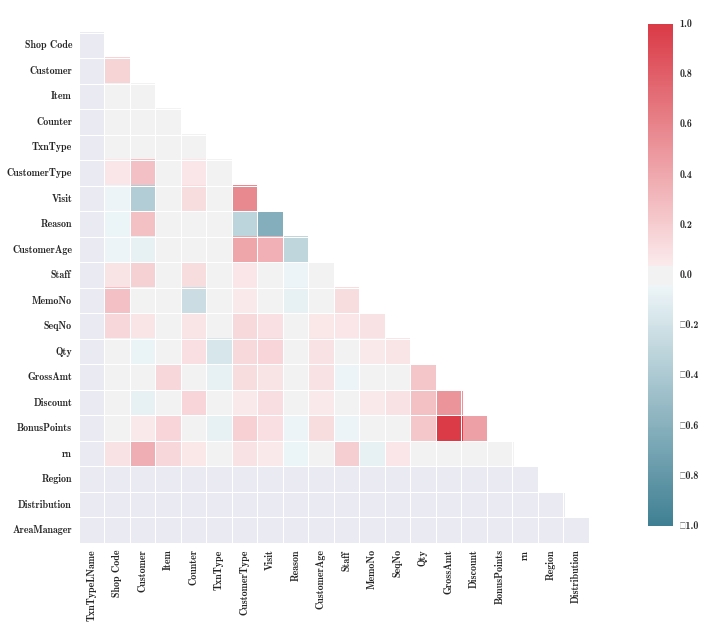

In [336]:
# look for highly correlated features

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(txn, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap)

# --> BonusPoints are of high correlation with GrossAmt
# --> take away BonusPoints from features
# --> no selected features are of high correlation

In [53]:
t_features

['TxnTypeLName',
 'POS Memo',
 'Shop',
 'Customer',
 'Item',
 'Staff',
 'SeqNo',
 'Qty',
 'GrossAmt',
 'Discount',
 'q1',
 'q2',
 'q3',
 'q4',
 'q5',
 'StoreGroup',
 'Description']

In [187]:
# Prepare data for classification

# calculate annual sales of the customer in txn's current year 

sales_by_cust_year = dict(txn.groupby(['Customer','Year'])['GrossAmt'].sum())

def checkCurrentYearSales(txn):
    return sales_by_cust_year[(txn['Customer'], txn['Year'])] 

txn['CurrentYearSales'] = txn.apply(checkCurrentYearSales, axis=1)

In [189]:
# calculate 3 yr total sales of the customer

checkTotalSales = dict(txn.groupby('Customer')['GrossAmt'].sum())
txn['TotalSales'] = txn.Customer.apply(lambda x: checkTotalSales[x])

In [204]:
# Classify bigSpender: if TotalSales > 75 percentile

percentile75 = np.percentile(txn['TotalSales'], 75)
txn['HighLTV'] = txn.TotalSales.apply(lambda x: (x > percentile75))
txn['HighLTV']

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16         True
17        False
18         True
19        False
20        False
21        False
22        False
23        False
24        False
25        False
27         True
29        False
30        False
31         True
          ...  
758261    False
758262    False
758263    False
758272    False
758273    False
758274    False
758275    False
758276    False
758277    False
758278    False
758280    False
758281    False
758282    False
758283    False
758284    False
758285    False
758286    False
758287     True
758288    False
758289    False
758290     True
758291     True
758292    False
758293    False
758294    False
758295    False
758296    False
758297    False
758298    False
758299     True
Name: HighLTV, dtype: bo

In [195]:
txn[['CurrentYearSales', 'TotalSales']].describe()

,CurrentYearSales,TotalSales
count,6.909090e+05,6.909090e+05
mean,1.307273e+05,2.665720e+05
std,2.086322e+05,4.946922e+05
min,-2.728484e-12,-2.728484e-12
25%,2.143440e+04,3.120000e+04
50%,7.438080e+04,1.233960e+05
75%,1.751880e+05,3.254784e+05
max,5.166346e+06,7.427503e+06


In [208]:
t_features

['TxnTypeLName',
 'POS Memo',
 'Shop',
 'Customer',
 'Item',
 'Staff',
 'SeqNo',
 'Qty',
 'GrossAmt',
 'Discount',
 'BonusPoints',
 'q1',
 'q2',
 'q3',
 'q4',
 'q5',
 'StoreGroup',
 'Description',
 'Year',
 'Month',
 'CurrentYearSales',
 'TotalSales',
 'BigSpender']

##Modeling: prepare training data format

In [201]:
# try RandomForest modeling

from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing


In [214]:
txn[t_features].iloc[:,:-1]

,TxnTypeLName,POS Memo,Shop,Customer,Item,Staff,SeqNo,Qty,GrossAmt,Discount,BonusPoints,q1,q2,q3,q4,q5,StoreGroup,Description,Year,Month,CurrentYearSales,TotalSales
0,CS,2012-01-01351386068777,LCCR,10949,11258,288,1,1,8361.6,0.0,1340.0,Female,Tourist,Others,Regular,55 or above,LANE CRAWFORD GROUP,Cash Sales,2012,1,25771.2,25771.2
1,CS,2012-01-01351353147766,HN LM,65112,8684,308,3,1,3120.0,0.0,500.0,Female,Local,Hong Kong,Regular,35 - 44,HARVEY NICHOLS,Cash Sales,2012,1,7425.6,7425.6
2,CS,2012-01-01351350592334,SOGO CWB,46273,11269,263,1,1,3744.0,0.0,600.0,Female,Tourist,Mainland China,Regular,24 or below,SOGO GROUP,Cash Sales,2012,1,6240.0,53976.0
3,CS,2012-01-01351380049020,FTW Boutique,64902,10716,241,1,1,2246.4,0.0,360.0,Female,Tourist,Mainland China,Regular,35 - 44,FESTIVAL WALK BOUTIQ,Cash Sales,2012,1,2246.4,2246.4
4,CS,2012-01-01351380049014,FTW Boutique,28240,8668,241,1,1,2995.2,0.0,480.0,Female,Local,Hong Kong,Non-regular,35 - 44,FESTIVAL WALK BOUTIQ,Cash Sales,2012,1,5491.2,5491.2
5,CS,2012-01-01351350637917,SOGO TST,36992,11640,115,1,1,1435.2,11.5,218.5,Female,Local,Hong Kong,Regular,35 - 44,SOGO GROUP,Cash Sales,2012,1,8486.4,18782.4
6,CS,2012-01-01351386068785,LCCR,64924,8849,232,2,1,2246.4,0.0,360.0,Female,Tourist,Mainland China,Regular,35 - 44,LANE CRAWFORD GROUP,Cash Sales,2012,1,32884.8,57470.4
7,CS,2012-01-01351350637924,SOGO TST,64941,11846,329,1,1,2620.8,0.0,420.0,Female,Tourist,Mainland China,Regular,24 or below,SOGO GROUP,Cash Sales,2012,1,47985.6,57532.8
8,CS,2012-01-01351358044358,LP,64932,11621,333,4,1,6177.6,0.0,990.0,Female,Local,Mainland China,Regular,25 - 34,SEIBU,Cash Sales,2012,1,73382.4,73382.4
9,CS,2012-01-01351386068784,LCCR,64904,12035,145,4,1,2620.8,0.0,420.0,Female,Tourist,Mainland China,Regular,25 - 34,LANE CRAWFORD GROUP,Cash Sales,2012,1,34257.6,34257.6


In [41]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(txn[t_features].iloc[:,:-1], txn.iloc[:,-1], test_size=0.3, random_state=12)

In [42]:
clf = RandomForestClassifier(n_estimators=1, max_depth=None, min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print "RandomForestClassifier:", scores

ValueError: could not convert string to float: LANE CRAWFORD GROUP

In [80]:
count = 0

temp = list(t_features)
temp.remove('POS Memo')
temp.remove('Customer')
temp.remove('Item')
temp.remove('SeqNo')
temp.remove('Qty')
temp.remove('Staff')
temp.remove('GrossAmt')
temp.remove('Discount')

for f in temp:
    count += 1
    print count, '.', f, ':'
    print txn[f].unique().tolist()
    print
    
# Observations:
# - TxnTypeName Redundant
# - trailing spaces in
#   TxnTypeName, q1 to q5, Description

1 . Shop :
['LCCR', 'HN LM', 'SOGO CWB', 'FTW Boutique', 'SOGO TST', 'LP', 'Macau New Yaohan', 'The ONE', 'LCTSQ', 'Central Boutique', 'Staff Sales', 'HN PP', 'FTW', 'LC IFC', 'Macau', 'WO MAIN', 'WO PLUS TSTE', 'HN The One', 'GUERLAIN STAFF SALES']

2 . q1 :
['Female', 'Male']

3 . q2 :
['Tourist', 'Local']

4 . q3 :
['Others', 'Hong Kong', 'Mainland China', 'Macau']

5 . q4 :
['Regular', 'Non-regular']

6 . q5 :
['55 or above', '35 - 44', '24 or below', '25 - 34', '45 - 54']

7 . StoreGroup :
['LANE CRAWFORD GROUP', 'HARVEY NICHOLS', 'SOGO GROUP', 'FESTIVAL WALK BOUTIQ', 'SEIBU', 'PANDA SOCIEDADE', 'BOUTIQUE', 'STAFF SALES POINT', 'WO']

8 . Description :
['Cash Sales', 'Exchange', 'Refund']

9 . Year :
[2012, 2013, 2014]

10 . Month :
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



In [76]:
pd.get_dummies?

In [78]:
# prepare dummy columns for nominal categories
txn[nominal_cat].dtypes

for f in nominal_cat:
    print 'create dummy columns for', f, ':'
    temp = pd.get_dummies(txn[f], prefix=str(f))
    print temp.columns.tolist()
    print

create dummy columns for Shop :
['Shop_Central Boutique', 'Shop_FTW', 'Shop_FTW Boutique', 'Shop_GUERLAIN STAFF SALES', 'Shop_HN LM', 'Shop_HN PP', 'Shop_HN The One', 'Shop_LC IFC', 'Shop_LCCR', 'Shop_LCTSQ', 'Shop_LP', 'Shop_Macau', 'Shop_Macau New Yaohan', 'Shop_SOGO CWB', 'Shop_SOGO TST', 'Shop_Staff Sales', 'Shop_The ONE', 'Shop_WO MAIN', 'Shop_WO PLUS TSTE']

create dummy columns for q1 :
['q1_Female', 'q1_Male']

create dummy columns for q2 :
['q2_Local', 'q2_Tourist']

create dummy columns for q3 :
['q3_Hong Kong', 'q3_Macau', 'q3_Mainland China', 'q3_Others']

create dummy columns for q4 :
['q4_Non-regular', 'q4_Regular']

create dummy columns for q5 :
['q5_24 or below', 'q5_25 - 34', 'q5_35 - 44', 'q5_45 - 54', 'q5_55 or above']

create dummy columns for StoreGroup :
['StoreGroup_BOUTIQUE', 'StoreGroup_FESTIVAL WALK BOUTIQ', 'StoreGroup_HARVEY NICHOLS', 'StoreGroup_LANE CRAWFORD GROUP', 'StoreGroup_PANDA SOCIEDADE', 'StoreGroup_SEIBU', 'StoreGroup_SOGO GROUP', 'StoreGroup_STAF

##Backup

In [29]:
# Check if the CounterNameLocal-null rows includes significant sales amount
# txn_CounterNameLocal_null keeps a copy of these rows for reference

txn_CounterNameLocal_null = txn[txn['CounterNameLocal'].isnull()].copy()
a = txn_CounterNameLocal_null['GrossAmt'].sum()
print 'total sales from CounterNameLocal-null rows:', a

b = txn['GrossAmt'].sum()
print 'total sales:', b

print '% of total = ', a/b

# --> 9% of total sales which is of some significance
# --> try to do some padding
# --> currently, drop CounterNameLocal for testing purpose - pad it and add it back later if necessary

txn.drop(txn[txn['CounterNameLocal'].isnull()].index)
print 'txn with CounterNameLocal null are dropped'

total sales from CounterNameLocal-null rows: 449963124.0
total sales: 4878287381.76
% of total =  0.0922379287621
txn with CounterNameLocal null are dropped
